In [39]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


In [40]:
dname <- '../../data/cache/obj_fibroblasts/'
fields_load <- c('meta_data', 'umap_after', 'umap_before', 'V', 'V_unweighted', 'effects_nested', 'effects_marginal')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [41]:
pryr::object_size(obj)

157,938,976 B

In [42]:
obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(tissue_cluster = case_when(
        tissue_cluster == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cluster
    ))

# %>% 
#     with(table(tissue_cluster))


In [43]:
# obj <- readRDS('../../data/cache/obj_fibroblasts.rds')

# % Variation by each tissue 

Within each PC, by (left) unweighted PCA and (right) weighted PCA. 


In [82]:
Xw <- split.data.frame(obj$V, obj$meta_data$Tissue) %>% 
    map(function(.SD) {
        apply(.SD, 2, var)
    }) %>% 
    bind_cols() %>% 
    tibble::rowid_to_column('PC') %>% 
    tidyr::gather(key, val, -PC) %>% 
    dplyr::mutate(Type = 'Weighted') 

Xu <- split.data.frame(obj$V_unweighted, obj$meta_data$Tissue) %>% 
    map(function(.SD) {
        apply(.SD, 2, var)
    }) %>% 
    bind_cols() %>% 
    tibble::rowid_to_column('PC') %>% 
    tidyr::gather(key, val, -PC) %>% 
    dplyr::mutate(Type = 'Unweighted') 

X <- rbind(Xw, Xu)

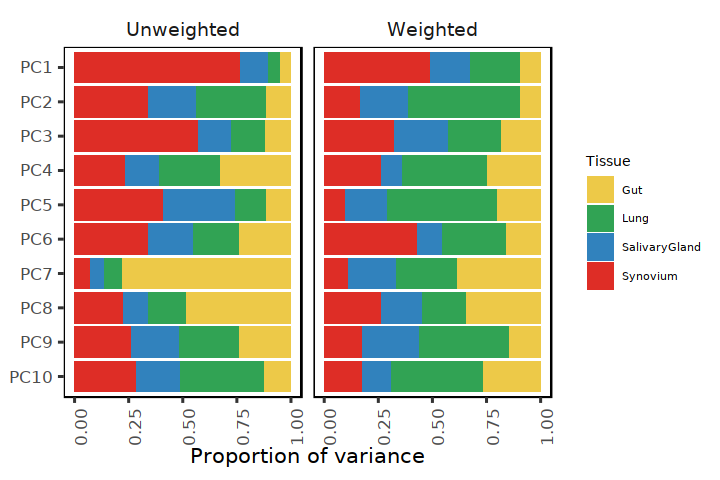

In [86]:
fig.size(4, 6)
p1 <- X %>% 
    subset(PC <= 10) %>% 
    dplyr::mutate(PC = factor(paste0('PC', PC), rev(paste0('PC', 1:50)))) %>% 
    ggplot(aes(PC, val, fill = key)) + 
        geom_bar(stat = 'identity', position = 'fill') + 
        coord_flip() + 
        theme(
            legend.text = element_text(size=6),
            legend.title = element_text(size=8),
            axis.title.y = element_blank(),
            axis.text.x = element_text(angle = 90, hjust = 1)
        ) + 
        facet_grid(.~Type) + 
        scale_fill_manual(values = palette_global[unique(X$key)]) + 
#         labs(title = 'Weighted') + 
        labs(y = 'Proportion of variance', fill = 'Tissue') + 
        NULL

p1



# UMAP 

- umap before
- by tissue and donor 



## Tissue

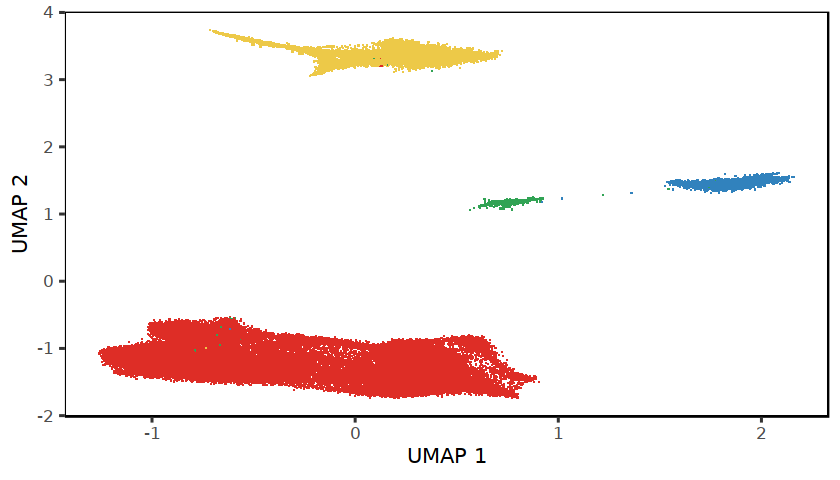

In [46]:
fig.size(4, 7)
p2 <- do_scatter(
    obj$umap_before, obj$meta_data, 'Tissue', 
    base_size = 14, pt_size = 6,
    palette_use = palette_global, 
    do_raster = FALSE, h = 3, w = 4,
    do_labels = FALSE, no_guides = TRUE
) + 
    NULL
p2


## Donor

In [47]:
# tissues <- c('Lung', 'Gut', 'Synovium', 'SalivaryGland')


# map(tissues, function(tissue) {
#     donors <- obj$meta_data %>% 
#         subset(Tissue == tissue) %>% 
#         with(unique(LibraryID))
#     ndonors <- length(donors)

#     library(RColorBrewer)
#     colors <- colorRampPalette(c('white', palette_global[tissue]))(ndonors + 1)[2:(1+ndonors)] ## ignore first value to omit white
#     writeLines(glue("`{donors}` = \'{colors}\',"))    
# })

In [48]:
## to plot tissue cells more clearly 
idx <- obj$meta_data %>% 
    cbind(data.frame(obj$umap_before)) %>% 
    tibble::rowid_to_column('idx') %>% 
    subset(
        (Tissue == 'Gut' & X2 > 2) | 
        (Tissue == 'Synovium' & X2 < 0) | 
        (Tissue == 'Lung' & X1 > 0 & X1 < 1 & X2 < 2 & X2 > 0.5) | 
        (Tissue == 'SalivaryGland' & X1 > 1.5 & X2 > 1) | 
        FALSE
    ) %>% 
    with(idx)


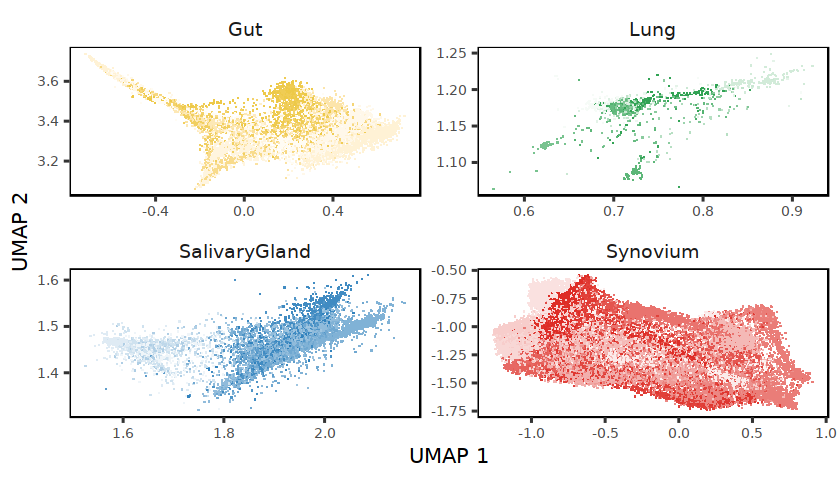

In [49]:
fig.size(4, 7)
p3 <- do_scatter(
    obj$umap_before[idx, ], obj$meta_data[idx, ],
#     obj$umap_before, obj$meta_data,
    'LibraryID', 
    base_size = 14, pt_size = 6,
    palette_use = palette_global, 
    do_raster = FALSE, h = 1.5, w = 2,
    do_labels = FALSE, no_guides = TRUE
) + 
    theme(axis.text = element_text(size = 8)) + 
    facet_wrap(~Tissue, nrow = 2, scales = 'free') + 
    NULL
p3


# Gut donor colors

In [50]:
# libs <- obj$meta_data %>% 
#     subset(Tissue == 'Gut') %>% 
#     dplyr::select(LibraryID) %>% 
#     unique() %>% 
#     with(LibraryID)

# cols <- tail(map(seq(0, 1, length.out = 1 + length(libs)), colour_ramp(c('white', '#edc948'))), -1)

# map2_chr(cols, libs, function(x, y) {
#     glue('`{y}` = \"{x}\",')
# }) %>% 
# writeLines()

# UMAPs (tissue clusters) 

In [51]:
# 


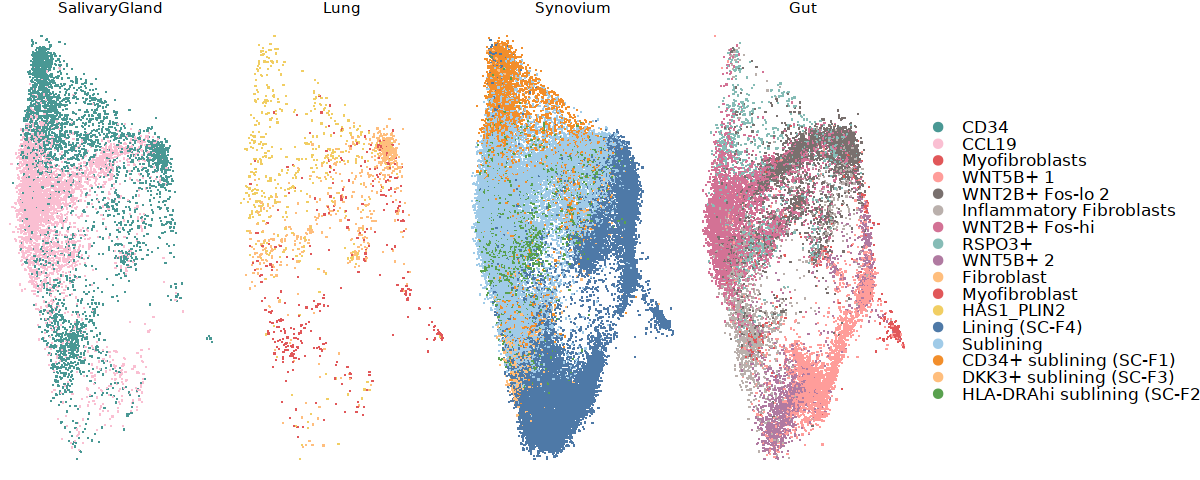

In [52]:
fig.size(4, 10)
# cbind(
#     bind_rows(map(fib, 'meta_data')),
#     bind_rows(map(map(fib, 'umap_after'), as.data.frame))
# ) %>% 
#     subset(!tissue_cell_type %in% c('UNKNOWN', 'DOUBLET', 'LOWQC')) %>% 
p4 <- do_scatter(
#     dplyr::select(obj$meta_data, X1 = UMAP1_tissue, X2 = UMAP2_tissue),
    obj$umap_after, 
    obj$meta_data %>% 
        dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))),
#         dplyr::mutate(tissue_cluster = factor(tissue_cluster, tissue_cluster_levels)), 
#             dplyr::mutate(.y, tissue_cell_type = gsub('Aviv_', '', tissue_cell_type)),
    'tissue_cluster',
    base_size = 10, 
    no_guides = FALSE, 
    do_labels = FALSE, 
    palette_use = palette_global[obj$meta_data$tissue_cluster], 
#     do_raster = TRUE, w = 1.5, h = 2
) + 
#     facet_wrap(~Tissue, nrow = 1, scales = 'free') + 
#             theme_test(base_size = 14) + 
    guides(
        color = guide_legend(
#                 nrow = round(length(unique(.y$tissue_cell_type)) / 2), 
#                 byrow = TRUE, 
            override.aes = list(size = 2, stroke = 1, shape = 16)
        )
    ) + 
#             theme(legend.key.height = unit(.1, 'cm'), legend.key.size = unit(.3, "cm")) + 
    theme_void() + 
    theme(
#         legend.position = 'bottom', legend.title.align = 0,
        legend.key.height = unit(0, 'cm'),
#                 legend.key = element_blank(), 
#                 legend.box.background = element_rect(color="red", size=2),
        legend.text = element_text(size = 10)
    ) + 
    labs(fill = '', color = '') + 
    coord_cartesian(clip = 'off') + 
    facet_wrap(~Tissue, nrow = 1, scales = 'free') + 
    NULL

p4


# Barplots (clusters) 

In [53]:
# fig.size(3, 5)
# p5 <- obj$meta_data %>% 
#     with(table(Tissue, Cluster)) %>% 
#     data.table() %>% 
# #     dplyr::mutate(Cluster = paste0('C', Cluster)) %>% 
#     ggplot(aes(Tissue, N, fill = Cluster)) + 
#         geom_bar(stat = 'identity', position = position_fill()) + 
# #         scale_fill_tableau('Tableau 20') + 
# #         scale_fill_manual(values = palette_global) + 
#         coord_flip() + 
#         scale_fill_manual(values = palette_global[unique(obj$meta_data$Cluster)])
# #         guides(fill = FALSE) + 
#         labs(y = 'Ratio of fibroblasts') + 
#         theme(
#             legend.position = 'bottom',
#             axis.title.y = element_blank()
#         ) + 
#         NULL

# p5 


In [62]:
# fig.size(3, 12)
# p5 <- obj$meta_data %>% 
#     with(table(LibraryID, Tissue, Cluster_name)) %>% 
#     prop.table(1) %>% 
#     data.table() %>% 
#     subset(N > 0) %>% 
#     ggplot(aes(LibraryID, N, fill = Cluster_name)) + 
#         geom_bar(stat = 'identity', position = position_fill()) + 
#         scale_fill_manual(values = palette_global[unique(obj$meta_data$Cluster_name)]) + 
#         theme(
#             axis.text.y= element_blank(), axis.ticks.y = element_blank(),
#             legend.position = 'bottom'
#         ) + 
#         facet_wrap(~Tissue, scales = 'free_y', nrow = 1) + 
# #         facet_grid(Tissue~., scales = 'free', space = 'free') + 
#         coord_flip() + 
#         labs(fill = '', y = 'Cluster Frequency in Sample') + 
#         NULL
# p5

# MYH11 and MYL9

In [55]:
# fig.size(3, 6)
# p5 <- obj$effects_nested %>% 
#     subset(feature %in% c('MYL9', 'MYH11')) %>% 
#     subset(Cluster == '13') %>% 
#     ggplot(aes(Tissue, beta, color = Tissue)) + 
#         geom_point() + 
#         geom_errorbar(aes(ymin = beta - 1.96 * sigma, ymax = beta + 1.96 * sigma), width = 0) + 
#         coord_flip() + 
# #         facet_grid(feature ~ ., space = "free", scales = "free") + 
#         facet_wrap(~feature, nrow = 1) + 
#         geom_hline(yintercept = c(0), linetype = 2) + 
#         labs(x = "", y = "Log2 fold change") +
#         guides(color = FALSE) + 
#         NULL

# p5


# Buechler et al enrichment

In [56]:
# saveRDS(eff, '../../data/cache/turley_eff.rds')
# saveRDS(gs_turley, '../../data/cache/turley_gs.rds')
gsea_res <- readRDS('../../data/cache/turley_gsea.rds')

In [57]:
fig.size(10, 8)
X <- gsea_res %>% 
#     subset(Cluster %in% c('5', '8', '9', '11', '4')) %>% 
#     subset(Cluster %in% c('5', '8', '9', '12')) %>% 
    subset(!grepl('_NA$', pathway)) %>% 
#     dplyr::mutate(SCORE = NES) %>% 
#     dplyr::mutate(SCORE = case_when(
#         padj < .05 & NES > 0 ~ NES, 
#         TRUE ~ 0
#     )) %>% 
    dplyr::mutate(SCORE = sign(ES) * -log10(pval)) %>% 
#     dplyr::select(Cluster, Tissue, pathway, SCORE) %>% 
    dplyr::select(Cluster_name, pathway, SCORE) %>% 
    tidyr::spread(Cluster_name, SCORE, fill = 0) %>% 
    tibble::column_to_rownames('pathway') %>% 
    as.matrix() %>% t() 

X <- pmax(X, 0)

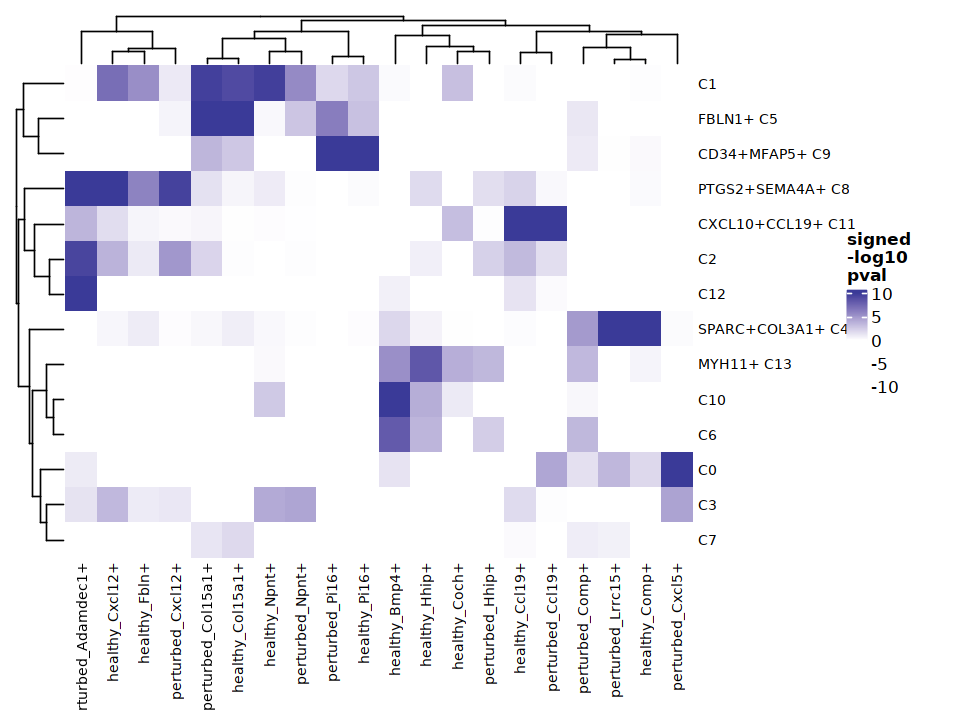

In [58]:
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 8))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 8))

p6 <- Heatmap(
    X,
    name = 'signed\n-log10\npval', 
    colorRamp2(c(-max(X), 0, max(X)), c('white', 'white', muted('blue'))),  
)

# p6 <- grid.grabExpr(draw(p6))


fig.size(6, 8)
p6 <- grid.grabExpr(draw(p6, padding = unit(c(1, 1, 1, 10), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings
wrap_elements(p6)



# Panels

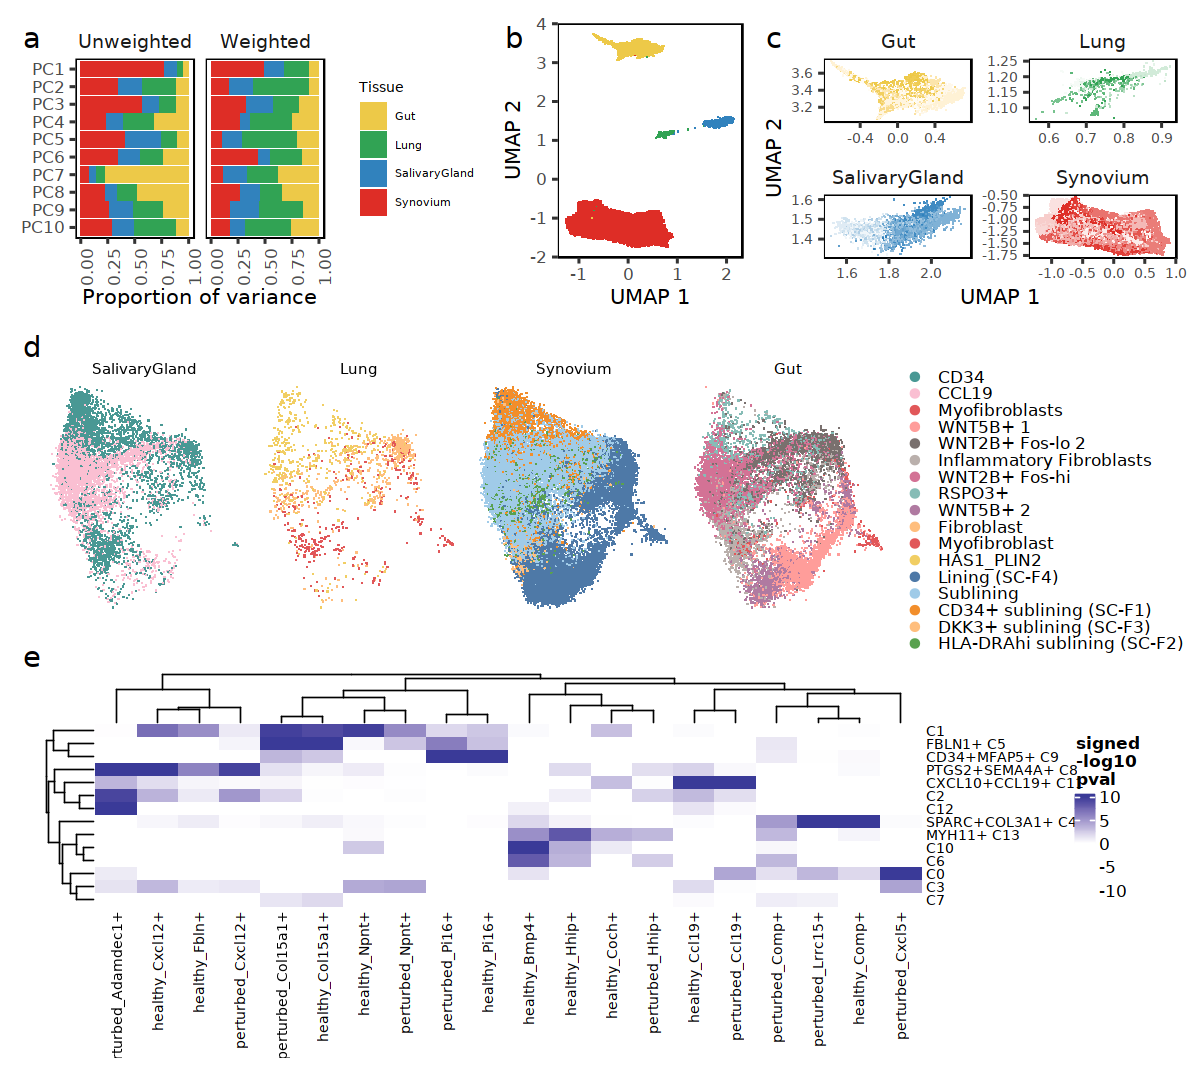

In [90]:
fig.size(9, 10)
(
    (
        (wrap_elements(full = p1) | wrap_elements(full = p2) | wrap_elements(full = p3)) + plot_layout(widths = c(2, 1, 1.8))
    ) / 
    (
        wrap_elements(p4)
    ) / 
    # (
    #     wrap_elements(p5)
    # ) / 
    ( 
        wrap_elements(p6) 
    )
) + 
    plot_layout(heights = c(1, 1, 1.5)) + 
    plot_annotation(tag_levels = 'a')

In [91]:
ggsave(
    filename = '../../manuscript/figures/SuppFigure2.pdf', 
    units = 'in', device = 'pdf', 
    height = 9, width = 10,
    useDingbats = FALSE
)
